# This is the notebook in which the code for the runs is made. First a standard run will be developed. Using this standard run, novel variants of this run can be made

In [1]:
# import all necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import yaml
import itertools

In [2]:
def open_yaml(file):
    """open a yaml file and return the contents"""
    with open(file, "r") as stream:
        settings = yaml.safe_load(stream)
        
    return settings

In [3]:
# define standard bar orientations, create an empty list for the trials

# PRF stimulus settings:
settings = open_yaml('expsettings_2R.yml')
pRF_stimulus_settings = settings['PRF stimulus settings']   
bar_pass_steps = pRF_stimulus_settings['Bar pass steps'] # number of steps the bar takes to traverse the aperture
blanks_length = pRF_stimulus_settings['Blanks length'] # length of interbar periods (-1 in orientation). like bar pass steps, in units of TRs or bar step length
bar_orientations = np.array(pRF_stimulus_settings['Bar orientations']) 
bar_step_length = pRF_stimulus_settings['Bar step length'] # in seconds. this is only used if Scanner sync is set to False
operating_system = settings['operating system']
win_size = np.array(settings['window']['size'])

In [4]:
# Create a list of the TR's per barpass or blank, blank lengths can easily be altered here.
# link this list with the orientations per subrun, to create the orientation of the bar at each TR

steps_array = bar_pass_steps*np.ones(len(bar_orientations))
blanks_array = blanks_length*np.ones(len(bar_orientations))

repeat_times = np.where(bar_orientations == -1, blanks_array, steps_array).astype(int)
repeats, bar_orientation = np.tile(repeat_times,3), np.tile(bar_orientations, 3)

bar_orientation_at_TR = np.repeat(bar_orientation, repeats)

In [5]:
# define the number of trials

trial_number = bar_pass_steps*len(np.where(bar_orientation != -1)[0]) + blanks_length*len(np.where(bar_orientation == -1)[0])

print('Expected number of TRs are:', trial_number)

Expected number of TRs are: 375


In [6]:
# define arrays for the bar positions and blanks (the window size is shortened by a tenth to ensure all bars are visible on the screen)

bar_pos_array = np.round((win_size[1]-win_size[1]/10)*np.linspace(-0.5,0.5, bar_pass_steps),6)


blank_array = np.zeros(blanks_length)

viol_pos = bar_pos_array[1:-1]
print(bar_pos_array)

[-486.       -434.842105 -383.684211 -332.526316 -281.368421 -230.210526
 -179.052632 -127.894737  -76.736842  -25.578947   25.578947   76.736842
  127.894737  179.052632  230.210526  281.368421  332.526316  383.684211
  434.842105  486.      ]


In [7]:
# define the bar position in each orientation, For regular display with circular aperture/square

bar_pos_in_ori = np.array([])

for i, orientation in enumerate(bar_orientation):
    if orientation == -1:
        bar_pos_in_ori = np.append(bar_pos_in_ori, blank_array)
    else:
        bar_pos_in_ori = np.append(bar_pos_in_ori, bar_pos_array)
# print(bar_pos_in_ori)

# define the bar direction at each TR
bar_direction_at_TR = np.round(np.random.rand(trial_number))

In [8]:
# Create the standard pRF trial list, from which each run can be defined
# The trial list will be loaded into a tsv file

trial_list = {"orientation_at_TR":[], 'pos_in_ori_at_TR':[], "direction_at_TR":[]}

for i in range(trial_number):
    trial_list['orientation_at_TR'].append(bar_orientation_at_TR[i])
    trial_list['pos_in_ori_at_TR'].append(bar_pos_in_ori[i])
    trial_list['direction_at_TR'].append(bar_direction_at_TR[i])
    
df = pd.DataFrame(trial_list)

os.makedirs('run_list', exist_ok = True)
df.to_csv('run_list/standard_run.tsv', sep='\t', index=True, na_rep='NA')


## Load the standard run into a numpy array, create a function to visualize it, and use it to create the new runs

In [9]:
data = np.genfromtxt(fname="run_list/standard_run.tsv", delimiter="\t", skip_header=1, filling_values=1)

standard_run = np.delete(data, 0, 1) 


In [10]:
def show_runs(run):
    """plot the runs for the prf checkers experiment with 0 and 180 being horizontal barpasses, from left to right and opposite, respectively, 
    and 90 and 270 degrees being vertical, downwards and upwards, respectively. 
    The run needs to be in an array, with in the first column a column with the angle of the barpass and in the second column, the positions of the bar"""
    
    # First, make arrays necessary for the plotting of the barpasses, with the positions of all the bars (haal 540 en -540 eruit)

    positions = np.round((win_size[1]-win_size[1]/10)*np.linspace(-0.5,0.5, 20),6)
    pos_forwards = np.array((range(20), positions))
    pos_backwards = np.array((range(19,-1,-1), positions))

    # Create empty arrays to alter with the bar positions of the run and create the figure with the different subplots  
    arrays = [np.zeros((20, 20)) for _ in range(len(run[:,1]))]
    average_arrays = [np.zeros((20, 20)) for _ in range(len(run[:,1]))]
    height_of_run = int(len(run[:,1])/20)
    fig, axs = plt.subplots(height_of_run, 20, figsize=(20, height_of_run))

    
    # Edit the arrays to that the values of the position of the bar at that moment becomes a 1 
    for i, value in enumerate(run[:,0]):

        for j, position in enumerate(pos_forwards[1,:]):
            if run[i,1] == position:
                line = int(pos_forwards[0,j])

                if value == 0:
                    arrays[i][:,line] = 1

                elif value == 90:
                    arrays[i][line,:] = 1
                    
                if value == 0 or value == 180:
                    average_arrays[i][:,line] = 1
                elif value == 90 or value ==270:
                    average_arrays[i][line,:] = 1
                    
        for j, position in enumerate(pos_backwards[1,:]):
            if run[i,1] == position:
                line = int(pos_backwards[0,j])

                if value == 180:
                    arrays[i][:,line] = 1
                    
                elif value == 270:
                    arrays[i][line,:] = 1
                    
                    
    # calculate the sum of all arrays, to show that all positions have been omitted once and been used as a violation once 
    average = np.sum(average_arrays, axis = 0)
    
    # Iterate through the 2D arrays and display each one in a subplot
    for ax, array in zip(axs.flat, arrays):
        ax.imshow(array, cmap = 'Dark2')
        ax.axis('off')

    plt.show()

    print('This is the average plot of all frames together')
    plt.imshow(average, cmap = 'Dark2')
    plt.show()

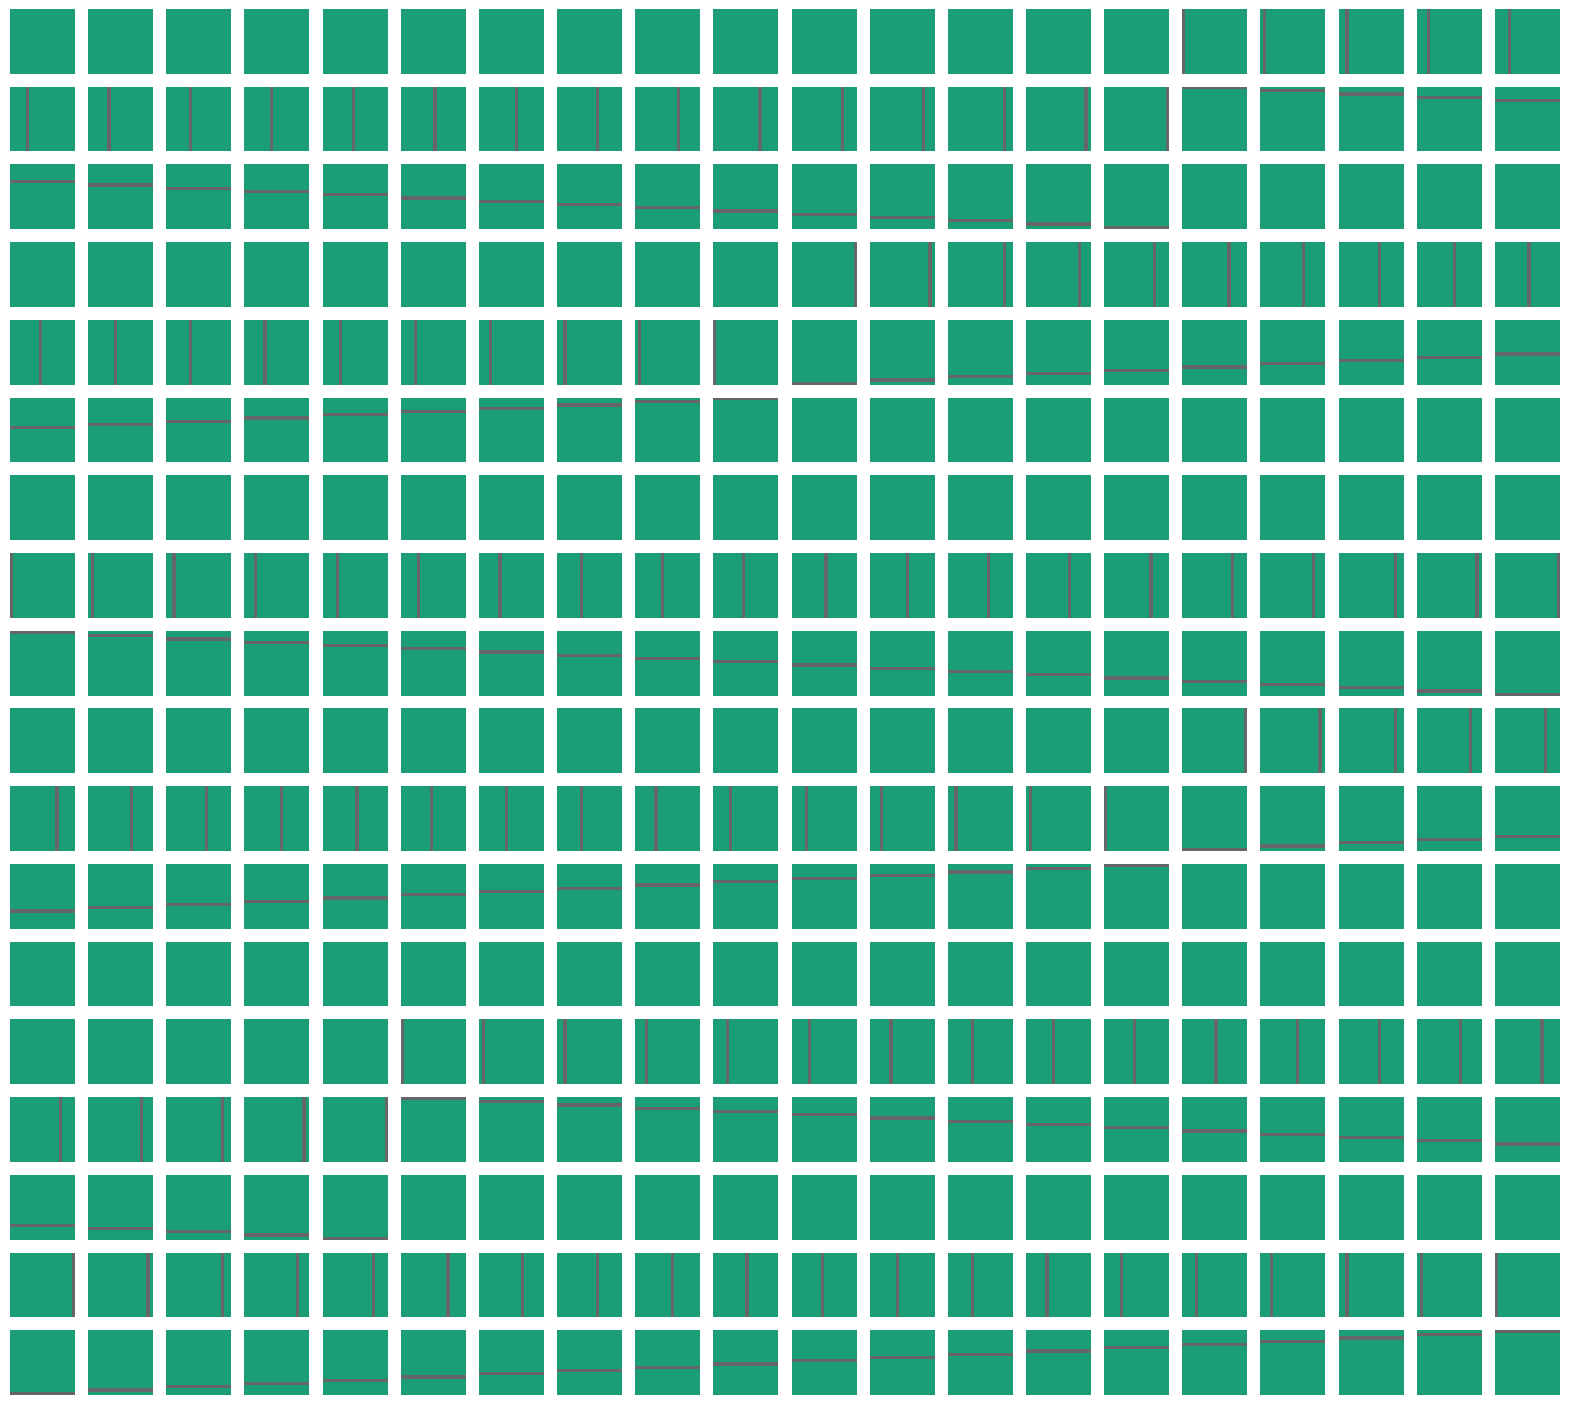

This is the average plot of all frames together


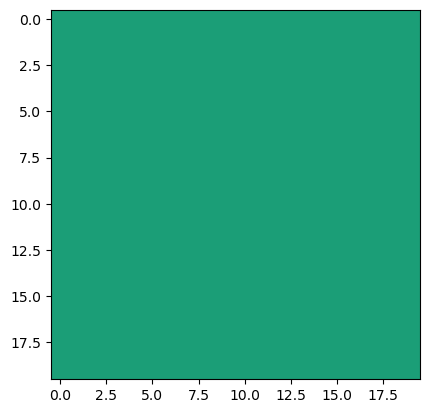

In [11]:
# Show how a regular (standard) run would look like
show_runs(standard_run)

## Alter the original pRF (Standard) run by introducing violations and omissions

In [12]:
def viol_4_omissions(n_pos:int=18):
    """function to make a random order of 18 positions to use as violations"""
    return np.random.permutation(np.arange(n_pos))

def omissions_2_barpasses(n_bps:int=6, 
                          n_pos:int=18,
                         min_diff:int=3):
    """function to make random positions to be violated in three consecutive runs. This is done for six barpasses (horizontal or vertical in both directions). 
    For the complete randomization of the omission/violation positions in three runs, this function has to be executed twice to find the horizontal and vertical positions.
    With this function, there are 3 omissions/violations per barpass and they have a minimum distance of 3 positions. """
    n_subblocks = int(n_pos//n_bps)
    n_bars_per_subblock = int(n_pos//n_subblocks)
    subblock_positions = np.arange(n_bars_per_subblock)
    total_diff = 2
    while total_diff != 0:
        all_bps = np.array([(n_bars_per_subblock*i)+np.random.permutation(subblock_positions) for i in range(n_subblocks)])
        total_diff = np.sum(np.diff(all_bps, axis=0)<min_diff)
          
    return all_bps

In [13]:
def bar_passes(run = standard_run):
        
    # find the values where the bar-passes start, seperate for the horizontal and vertical bar-passes.
    bp_v = []
    bp_h = []
    bp = []
    
    for i, value in enumerate(run[:,0]):
        if value == 0 or value == 180:
            if value != run[(i-1),0]:
                bp_v.append(i)
        elif value == 90 or value == 270:
            if value != run[(i-1),0]:
                bp_h.append(i)
        if value == 0 or value == 90 or value == 180 or value == 270:
            if value != run[(i-1),0]:
                bp.append(i)
    
    return bp_v, bp_h, bp

In [14]:
def configurations(run = standard_run, win_size = win_size):

    positions = np.round((win_size[1]-win_size[1]/10)*np.linspace(-0.5,0.5, 20),6)
    posi = positions[1:-1]

    viols = (np.vstack((viol_4_omissions(), viol_4_omissions()))).T

    oms_h = omissions_2_barpasses()
    oms_v = omissions_2_barpasses()
        
    # create new runs as a copy of the original run, which we can alter to our wished new configurations
    violated_run = run.copy()
    omission_run = run.copy()
    empty_run = run.copy()
    empty_run[:,0] = -1

    bp_v, bp_h, bp = bar_passes()

    # Use the indices of the bar-passes +1 (as we are not violating/omitting the first and the last position) as the start of the bar-pass. Then omitt/violate the pre-determined position (with the pre-determined violation)
    for i, index in enumerate(bp_v):
        for j, value in enumerate(posi):
            h_viol = posi[(viols[j,0])]
            viol_index = int(index + j + 1)
            for k in range(3):
                if j == oms_v[k,i]:
                
                    # use the just chosen index and violate it with the first value of the shuffled violations list for the violation and empty run and create an omission in the omission run.
                    violated_run[viol_index,1] = h_viol
                    violated_run[viol_index,0] = 90
                    omission_run[viol_index,0] = -1
                    empty_run[viol_index,1] = h_viol
                    empty_run[viol_index,0] = 90
    
    # Do the same for the horizontal bar-passes
    for i, index in enumerate(bp_h):
        for j, value in enumerate(posi):    
            v_viol = posi[viols[j,1]]
            viol_index = int(index + j + 1)
            for k in range(3):
                if j == oms_h[k,i]:
                    
                    violated_run[viol_index,1] = v_viol
                    violated_run[viol_index,0] = 0
                    omission_run[viol_index,0] = -1
                    empty_run[viol_index,1] = v_viol
                    empty_run[viol_index,0] = 0

    return violated_run, omission_run, empty_run

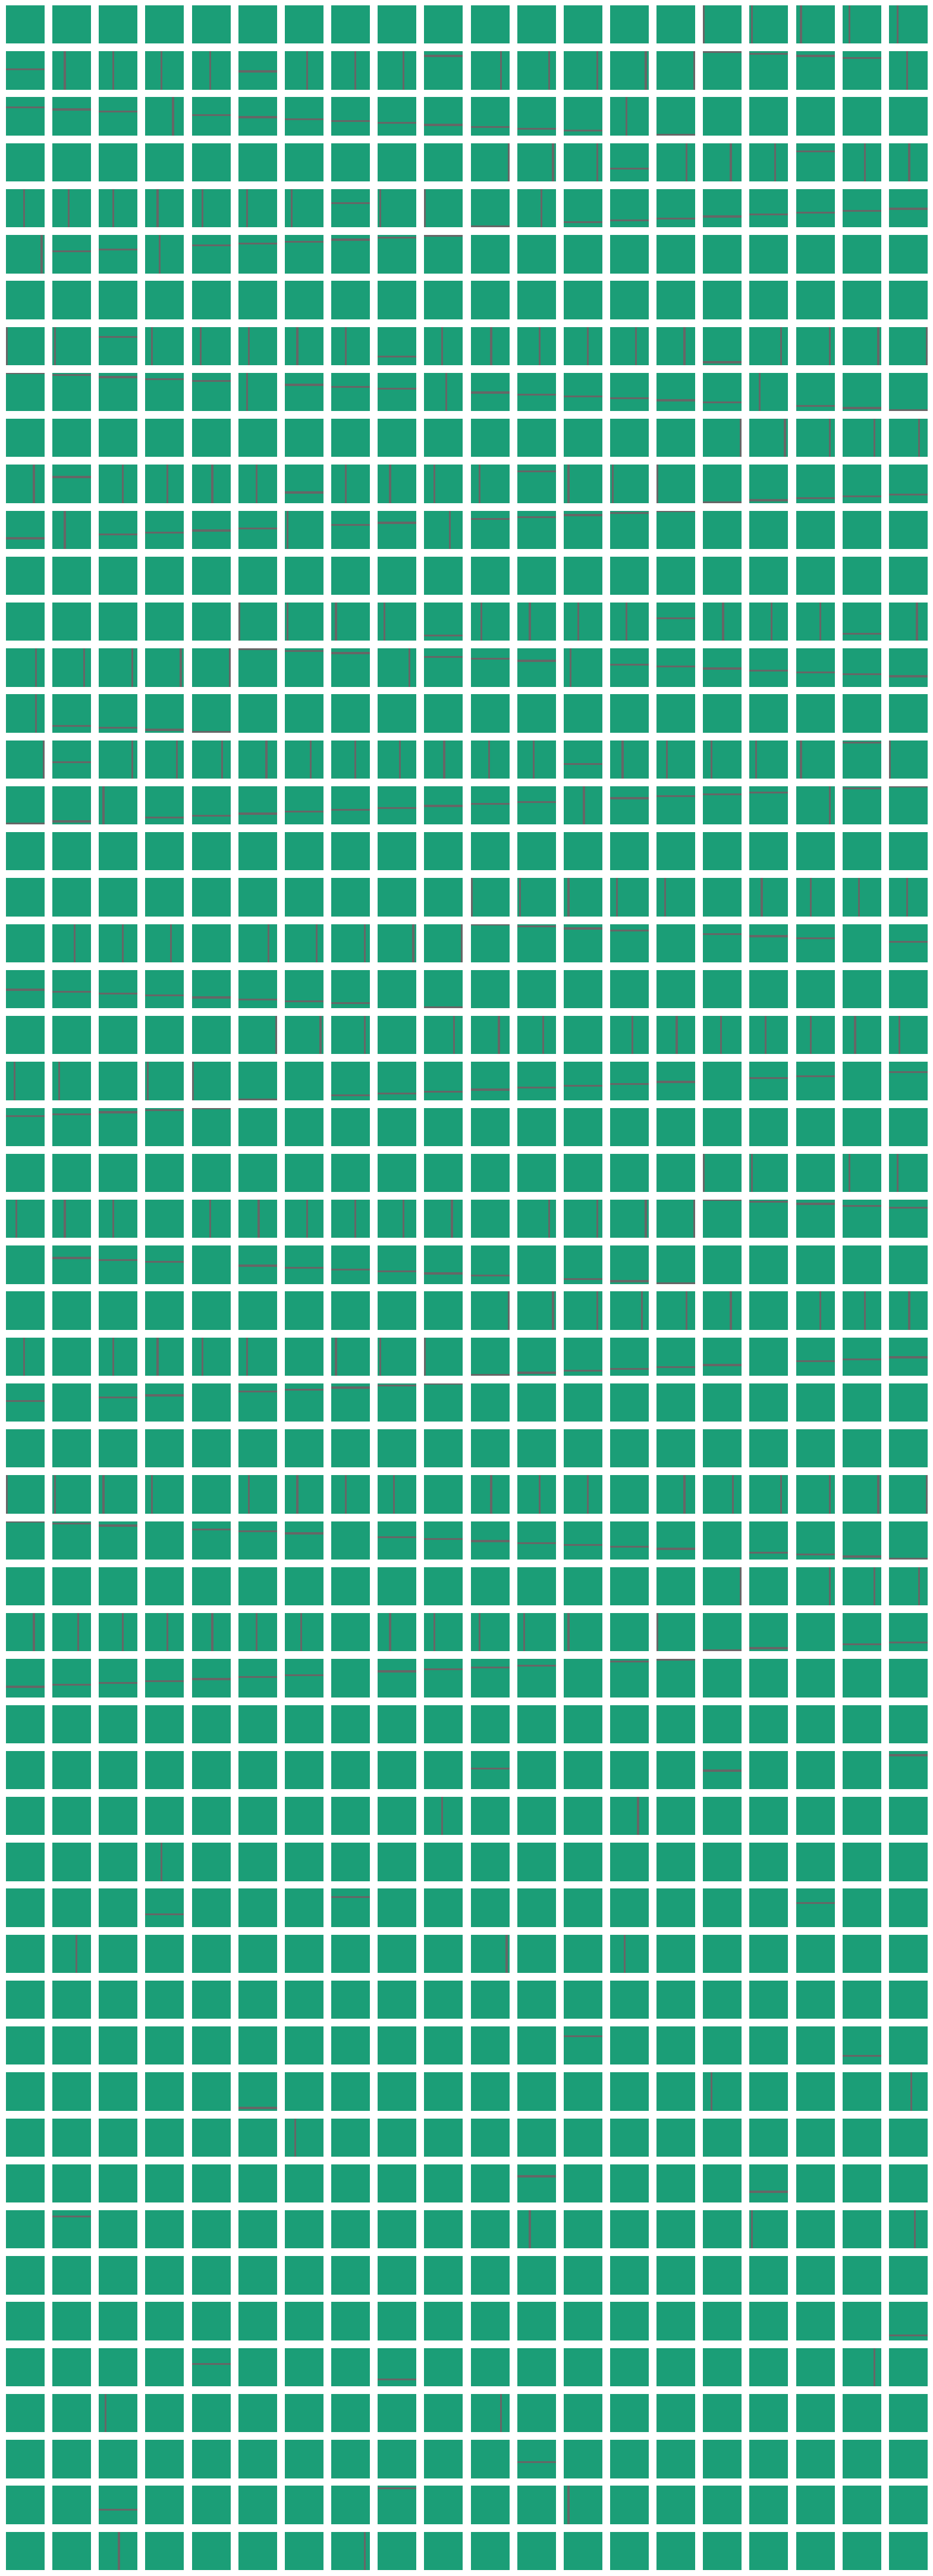

This is the average plot of all frames together


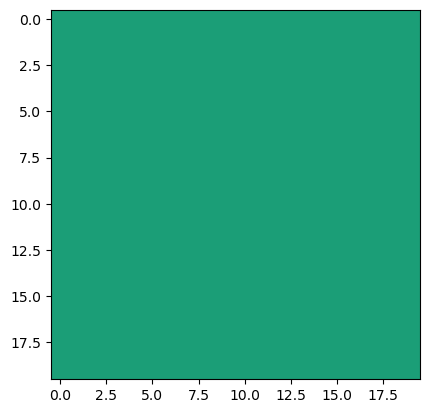

In [15]:
violated_run, omitted_run, empty_run = configurations()
# Show an example of a violation, omission and empty run
combined_run = np.concatenate((violated_run, omitted_run, empty_run))
show_runs(combined_run)

## Create runs for each subject and store the runs per sub in a .tsv file

In [16]:
def permute_runs():
    """create three different orders of runs, each with one violation, one omission and one empty subrun in a different order"""

    # Create an initial examplary order of the three subruns to make up one total run
    order = ['e', 'o', 'v']

    # Create a list with all possible permutations of the run
    permutations = list(itertools.permutations(order))

    # Ensure that there are two lists with three unique permutations, where no subrun occurs at the same position
    unique_perms_1 = []
    unique_perms_2 = []
    for i, permutation in enumerate(permutations):
        if i == 0:
            unique_perms_1.append(permutation)
        else:
            if any(config == unique_perms_1[0][j] for j, config in enumerate(permutation)):
                unique_perms_2.append(permutation)
            else:
                unique_perms_1.append(permutation)
    
    # Elongate the list of permutations to choose from to be able to create more runs per subject (just in case)
    # The main focus is on the first three unique permutations, the second three are not unique anymore and are only added for extra data collection if there is time
    total_perms_1 = unique_perms_1 + unique_perms_2
    total_perms_2 = unique_perms_2 + unique_perms_1

    return total_perms_1, total_perms_2

In [17]:
def permutation_order():
    """Makes a randomly shuffled list with the six possible permutations for the first three (and second three) runs"""
    
    permutation_order = [0,1,2]
    permutation_order_1 = [3,4,5]
    p_o_p = np.array(list(itertools.permutations(permutation_order)))
    p_o_p_1 = np.array(list(itertools.permutations(permutation_order_1)))
    p_o_p = np.hstack((p_o_p, p_o_p_1))
    random.shuffle(p_o_p)

    return p_o_p


In [18]:
def runs_per_subject():
    """creates a dictionary with a key for twelve subjects with a list of runs (with subruns) per subject"""

    # Create two lists with permutations of runs with different orders of subruns and a further list to permute these runs.
    tp1, tp2 = permute_runs()
    p_o_p = permutation_order()

    subject_run = {key: [] for key in range(1, 13)}

    for i, value in enumerate(p_o_p):
        for j in range(6):
            subject_run[(i+1)].append(tp1[value[j]])
            subject_run[(i+7)].append(tp2[value[j]])

    return subject_run

### Combine the previous functions to make eight runs for all the twelve participants

In [19]:
# Make three regular regular pRF runs and name them 1, 3 and 5

run_length = 375

for i in range(12):

    for j in range(3):

        if i >= 9:
            run_name = 'sub-0' + str((i+1)) + '_run-' + str((2*j+1))
        elif i < 9:
            run_name = 'sub-00' + str((i+1)) + '_run-' + str((2*j+1))

        trial_list = {"orientation_at_TR":[], "pos_in_ori_at_TR":[], "direction_at_TR":[]}

        for k in range(run_length):

            trial_list["orientation_at_TR"].append(standard_run[k,0])
            trial_list['pos_in_ori_at_TR'].append(standard_run[k,1])
            trial_list['direction_at_TR'].append(standard_run[k,2])

        df = pd.DataFrame(trial_list)
        # save the dataframe as a .tsv file with the subject & run name
        name = 'run_list/' + run_name + '.tsv'
        df.to_csv(name, sep='\t', index=True, na_rep='NA')

In [20]:
# create new violations, omissions and empty runs for every participant

# load all the necessary variables using previous functions
sub_run_length = 125
subject_run = runs_per_subject()

# Loop over each subject in the subject run dictionary and create new violation, omission and empty runs for each subject
# In the dictionary each subject has 6 runs,listed as tuples, which each consist of 3 subruns: one violation ('v'), one omission ("o") and one empty run ("e"), in pseudo-random order
for i, subject in enumerate(subject_run):
    v, o, e = configurations()

    # Loop over each run per subject, there are six per subject. Give each run, for each subject, a name in the format of sub-0xx_run-x starting at sub-001_run-3
    for run, run_order in enumerate(subject_run[subject]):
        if run < 3:
            if subject >= 10:
                run_name = 'sub-0' + str(subject) + '_run-' + str((2*run+2))
            elif subject <10:
                run_name = 'sub-00' + str(subject) + '_run-' + str((2*run+2))
        else: 
            if subject >= 10:
                run_name = 'sub-0' + str(subject) + '_run-' + str((run+4))
            elif subject <10:
                run_name = 'sub-00' + str(subject) + '_run-' + str((run+4))

        # make an empty dictionary for each run  
        trial_list = {"orientation_at_TR":[], "pos_in_ori_at_TR":[], "direction_at_TR":[]}

        # loop over the order of the runs, to be able to use the assigned subrun, add the info of each of the three subruns, totalling to one run in a dictionary called 'trial list'
        # Each total run is saved in a pandas dataframe and subsequently saved as a .tsv file with the assigned name for that run
        for k, subrun in enumerate(run_order): 

            if run == 0 or run == 3:
                
                for l in range(sub_run_length):
                    if subrun == 'v':
                        trial_list["orientation_at_TR"].append(v[l,0])
                        trial_list['pos_in_ori_at_TR'].append(v[l,1])
                        trial_list['direction_at_TR'].append(v[l,2])
                    elif subrun == 'o':
                        trial_list["orientation_at_TR"].append(o[l,0])
                        trial_list['pos_in_ori_at_TR'].append(o[l,1])
                        trial_list['direction_at_TR'].append(o[l,2])
                    elif subrun == 'e':
                        trial_list["orientation_at_TR"].append(e[l,0])
                        trial_list['pos_in_ori_at_TR'].append(e[l,1])
                        trial_list['direction_at_TR'].append(e[l,2])
            
            elif run == 1 or run == 4:

                for l in range(sub_run_length,(2*sub_run_length)):
                    if subrun == 'v':
                        trial_list["orientation_at_TR"].append(v[l,0])
                        trial_list['pos_in_ori_at_TR'].append(v[l,1])
                        trial_list['direction_at_TR'].append(v[l,2])
                    elif subrun == 'o':
                        trial_list["orientation_at_TR"].append(o[l,0])
                        trial_list['pos_in_ori_at_TR'].append(o[l,1])
                        trial_list['direction_at_TR'].append(o[l,2])
                    elif subrun == 'e':
                        trial_list["orientation_at_TR"].append(e[l,0])
                        trial_list['pos_in_ori_at_TR'].append(e[l,1])
                        trial_list['direction_at_TR'].append(e[l,2])

            elif run == 2 or run == 5:

                for l in range((2*sub_run_length), (3*sub_run_length)):
                    if subrun == 'v':
                        trial_list["orientation_at_TR"].append(v[l,0])
                        trial_list['pos_in_ori_at_TR'].append(v[l,1])
                        trial_list['direction_at_TR'].append(v[l,2])
                    elif subrun == 'o':
                        trial_list["orientation_at_TR"].append(o[l,0])
                        trial_list['pos_in_ori_at_TR'].append(o[l,1])
                        trial_list['direction_at_TR'].append(o[l,2])
                    elif subrun == 'e':
                        trial_list["orientation_at_TR"].append(e[l,0])
                        trial_list['pos_in_ori_at_TR'].append(e[l,1])
                        trial_list['direction_at_TR'].append(e[l,2])

        # transform the dictionary of each run to a dataframe, which can be saved as a .tsv file with the run name. This can then be used in the session.py script.
        df = pd.DataFrame(trial_list)

        # save the dataframe as a .tsv file with the subject & run name
        name = 'run_list/' + run_name + '.tsv'
        df.to_csv(name, sep='\t', index=True, na_rep='NA')



### Create an extra test run(sub-000), which does not have to be unique to every participant 

In [21]:
for j in range(3):

    run_name = 'sub-000_run-' + str((2*j+1))


    trial_list = {"orientation_at_TR":[], "pos_in_ori_at_TR":[], "direction_at_TR":[]}

    for k in range(run_length):

        trial_list["orientation_at_TR"].append(standard_run[k,0])
        trial_list['pos_in_ori_at_TR'].append(standard_run[k,1])
        trial_list['direction_at_TR'].append(standard_run[k,2])

    df = pd.DataFrame(trial_list)
    # save the dataframe as a .tsv file with the subject & run name
    name = 'run_list/' + run_name + '.tsv'
    df.to_csv(name, sep='\t', index=True, na_rep='NA')

In [22]:
random_subject = random.randint(1,12)
rs_run_order = subject_run[random_subject]

# Loop over each run per subject, there are six per subject. Give each run, for each subject, a name in the format of sub-0xx_run-x starting at sub-001_run-3
for run, run_order in enumerate(rs_run_order):
    if run < 3:
        run_name = 'sub-000_run-' + str((2*run+2))
    else: 
        run_name = 'sub-000_run-' + str((run+4))


    # make an empty dictionary for each run  
    trial_list = {"orientation_at_TR":[], "pos_in_ori_at_TR":[], "direction_at_TR":[]}

    # loop over the order of the runs, to be able to use the assigned subrun, add the info of each of the three subruns, totalling to one run in a dictionary called 'trial list'
    # Each total run is saved in a pandas dataframe and subsequently saved as a .tsv file with the assigned name for that run
    for k, subrun in enumerate(run_order): 

        if run == 0 or run == 3:
            
            for l in range(sub_run_length):
                if subrun == 'v':
                    trial_list["orientation_at_TR"].append(v[l,0])
                    trial_list['pos_in_ori_at_TR'].append(v[l,1])
                    trial_list['direction_at_TR'].append(v[l,2])
                elif subrun == 'o':
                    trial_list["orientation_at_TR"].append(o[l,0])
                    trial_list['pos_in_ori_at_TR'].append(o[l,1])
                    trial_list['direction_at_TR'].append(o[l,2])
                elif subrun == 'e':
                    trial_list["orientation_at_TR"].append(e[l,0])
                    trial_list['pos_in_ori_at_TR'].append(e[l,1])
                    trial_list['direction_at_TR'].append(e[l,2])
        
        elif run == 1 or run == 4:

            for l in range(sub_run_length,(2*sub_run_length)):
                if subrun == 'v':
                    trial_list["orientation_at_TR"].append(v[l,0])
                    trial_list['pos_in_ori_at_TR'].append(v[l,1])
                    trial_list['direction_at_TR'].append(v[l,2])
                elif subrun == 'o':
                    trial_list["orientation_at_TR"].append(o[l,0])
                    trial_list['pos_in_ori_at_TR'].append(o[l,1])
                    trial_list['direction_at_TR'].append(o[l,2])
                elif subrun == 'e':
                    trial_list["orientation_at_TR"].append(e[l,0])
                    trial_list['pos_in_ori_at_TR'].append(e[l,1])
                    trial_list['direction_at_TR'].append(e[l,2])

        elif run == 2 or run == 5:

            for l in range((2*sub_run_length), (3*sub_run_length)):
                if subrun == 'v':
                    trial_list["orientation_at_TR"].append(v[l,0])
                    trial_list['pos_in_ori_at_TR'].append(v[l,1])
                    trial_list['direction_at_TR'].append(v[l,2])
                elif subrun == 'o':
                    trial_list["orientation_at_TR"].append(o[l,0])
                    trial_list['pos_in_ori_at_TR'].append(o[l,1])
                    trial_list['direction_at_TR'].append(o[l,2])
                elif subrun == 'e':
                    trial_list["orientation_at_TR"].append(e[l,0])
                    trial_list['pos_in_ori_at_TR'].append(e[l,1])
                    trial_list['direction_at_TR'].append(e[l,2])

    # transform the dictionary of each run to a dataframe, which can be saved as a .tsv file with the run name. This can then be used in the session.py script.
    df = pd.DataFrame(trial_list)

    # save the dataframe as a .tsv file with the subject & run name
    name = 'run_list/' + run_name + '.tsv'
    df.to_csv(name, sep='\t', index=True, na_rep='NA')

In [23]:
# make two regular pRF-runs for the participants to perform outside of the scanner before performing the real experiment, to get familiar with the regular pRF sequence

run_length = 375

for i in range(12):

    for j in range(2):

        if i >= 9:
            run_name = 'sub-0' + str((i+1)) + '_run-10' + str((j+1))
        elif i < 9:
            run_name = 'sub-00' + str((i+1)) + '_run-10' + str((j+1))

        trial_list = {"orientation_at_TR":[], "pos_in_ori_at_TR":[], "direction_at_TR":[]}

        for k in range(run_length):

            trial_list["orientation_at_TR"].append(standard_run[k,0])
            trial_list['pos_in_ori_at_TR'].append(standard_run[k,1])
            trial_list['direction_at_TR'].append(standard_run[k,2])

        df = pd.DataFrame(trial_list)
        # save the dataframe as a .tsv file with the subject & run name
        name = 'run_list/' + run_name + '.tsv'
        df.to_csv(name, sep='\t', index=True, na_rep='NA')